In [1]:
import os
# Configuración inicial
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [2]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import StandardScaler
from scipy.sparse.linalg import norm
from scipy.stats import zscore
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, accuracy_score, f1_score

# Cargar los datasets
train_data = pd.read_csv("divisonDatos/train_data.csv", sep=";")
val_data = pd.read_csv("divisonDatos/val_data.csv",sep=";")
test_data = pd.read_csv("divisonDatos/test_data.csv",sep=";")

train_data

,Label,Texto
0,0,rita maestre anuncia que en agosto llegarán 34...
1,0,psoe aclara que la mesa de negociación debe se...
2,0,campaña por la educación nueva propuesta legis...
3,1,educación y formación profesional destina más ...
4,1,la resurrección del presupuesto de andalucía y...
...,...,...
51988,0,nueva fórmula de alfonso guerra contra los par...
51989,0,el ministerio de sanidad lanza una campaña par...
51990,0,feijóo ensaya para las generales y moreno se s...
51991,0,el ministerio de educación anuncia nuevas medi...


In [5]:


# Preprocesamiento mínimo para asegurarse de que no haya valores nulos
train_data = train_data.dropna(subset=['Texto', 'Label'])
val_data = val_data.dropna(subset=['Texto', 'Label'])
test_data = test_data.dropna(subset=['Texto', 'Label'])

# Separar características y etiquetas
X_train = train_data['Texto']
y_train = train_data['Label']

X_val = val_data['Texto']
y_val = val_data['Label']

X_test = test_data['Texto']
y_test = test_data['Label']

# Paso 1: Vectorización con n-grams
tfidf_vectorizer_ngrams = TfidfVectorizer(ngram_range=(1, 2), max_features=10000)
X_train_vec = tfidf_vectorizer_ngrams.fit_transform(X_train)
X_val_vec = tfidf_vectorizer_ngrams.transform(X_val)
X_test_vec = tfidf_vectorizer_ngrams.transform(X_test)

# Paso 2: Selección de características
selector = SelectKBest(chi2, k=3000)
X_train_reduced = selector.fit_transform(X_train_vec, y_train)
X_val_reduced = selector.transform(X_val_vec)
X_test_reduced = selector.transform(X_test_vec)

# Paso 3: Normalización
scaler = StandardScaler(with_mean=False)
X_train_normalized = scaler.fit_transform(X_train_reduced)
X_val_normalized = scaler.transform(X_val_reduced)
X_test_normalized = scaler.transform(X_test_reduced)

# Paso 4: Filtrado de ruido (solo en el conjunto de entrenamiento)
row_norms = norm(X_train_normalized, axis=1)
z_scores = zscore(row_norms)
mask = np.abs(z_scores) < 2.5
X_train_cleaned = X_train_normalized[mask]
y_train_cleaned = y_train[mask]

class LogisticRegressionGD:
    def __init__(self, learning_rate=0.01, epochs=1000, tolerance=1e-5, decay_rate=0.0, momentum=0.0):
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.tolerance = tolerance
        self.decay_rate = decay_rate  # Tasa de decaída para el learning rate
        self.momentum = momentum      # Momento para el optimizador
        self.velocity_weights = None  # Velocidad para momento (pesos)
        self.velocity_bias = 0        # Velocidad para momento (bias)

        # Métricas por época
        self.losses_train = []
        self.losses_val = []
        self.accuracies_train = []
        self.accuracies_val = []

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def fit(self, X_train, y_train, X_val, y_val):
        n_samples, n_features = X_train.shape
        self.weights = np.zeros(n_features)
        self.bias = 0
        self.velocity_weights = np.zeros(n_features)

        for epoch in range(self.epochs):
            # Predicciones en entrenamiento
            linear_model_train = np.dot(X_train, self.weights) + self.bias
            y_pred_train = self.sigmoid(linear_model_train)

            # Pérdida en entrenamiento
            loss_train = -np.mean(y_train * np.log(y_pred_train + 1e-9) +
                                  (1 - y_train) * np.log(1 - y_pred_train + 1e-9))
            self.losses_train.append(loss_train)

            # Precisión en entrenamiento
            y_pred_train_class = [1 if i > 0.5 else 0 for i in y_pred_train]
            accuracy_train = np.mean(y_pred_train_class == y_train)
            self.accuracies_train.append(accuracy_train)

            # Gradientes
            dw = (1 / n_samples) * np.dot(X_train.T, (y_pred_train - y_train))
            db = (1 / n_samples) * np.sum(y_pred_train - y_train)

            # Actualización con momento
            self.velocity_weights = self.momentum * self.velocity_weights - self.learning_rate * dw
            self.velocity_bias = self.momentum * self.velocity_bias - self.learning_rate * db
            self.weights += self.velocity_weights
            self.bias += self.velocity_bias

            # Decaída del learning rate
            self.learning_rate *= (1 / (1 + self.decay_rate * epoch))

            # Predicciones en validación
            linear_model_val = np.dot(X_val, self.weights) + self.bias
            y_pred_val = self.sigmoid(linear_model_val)

            # Pérdida en validación
            loss_val = -np.mean(y_val * np.log(y_pred_val + 1e-9) +
                                (1 - y_val) * np.log(1 - y_pred_val + 1e-9))
            self.losses_val.append(loss_val)

            # Precisión en validación
            y_pred_val_class = [1 if i > 0.5 else 0 for i in y_pred_val]
            accuracy_val = np.mean(y_pred_val_class == y_val)
            self.accuracies_val.append(accuracy_val)

            # ——— AQUÍ IMPRIMIMOS CADA 10 ÉPOCAS ———
            if epoch % 10 == 0:
                print(f"Epoch {epoch:4d} | "
                      f"Loss_Train: {loss_train:.4f} | Loss_Val: {loss_val:.4f} | "
                      f"Acc_Train: {accuracy_train:.4f} | Acc_Val: {accuracy_val:.4f}")

            # Verificar convergencia
            if np.linalg.norm(dw) < self.tolerance and abs(db) < self.tolerance:
                print(f"Converged at epoch {epoch}")
                break

    def predict(self, X, threshold=0.5):
        linear_model = np.dot(X, self.weights) + self.bias
        y_predicted = self.sigmoid(linear_model)
        return [1 if i > threshold else 0 for i in y_predicted]



# Entrenamiento del modelo con validación
gd_model = LogisticRegressionGD(
    learning_rate=0.001, epochs=5000, tolerance=1e-5, decay_rate=1e-12, momentum=0.9
)
gd_model.fit(
    X_train_cleaned.toarray(),  # Datos de entrenamiento
    y_train_cleaned,
    X_val_normalized.toarray(),  # Datos de validación
    y_val
)


# Evaluación en validación
y_val_pred = gd_model.predict(X_val_normalized.toarray(), threshold=0.6)
val_precision = precision_score(y_val, y_val_pred)
val_accuracy = accuracy_score(y_val, y_val_pred)
val_f1 = f1_score(y_val, y_val_pred)
print("\nValidation Metrics:")
print(f"Precision: {val_precision:.4f}")
print(f"Accuracy: {val_accuracy:.4f}")
print(f"F1-Score: {val_f1:.4f}")

# Evaluación en prueba
y_test_pred = gd_model.predict(X_test_normalized.toarray(), threshold=0.6)
test_precision = precision_score(y_test, y_test_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)
print("\nTest Metrics:")
print(f"Precision: {test_precision:.4f}")
print(f"Accuracy: {test_accuracy:.4f}")
print(f"F1-Score: {test_f1:.4f}")


Epoch    0 | Loss_Train: 0.6931 | Loss_Val: 0.6927 | Acc_Train: 0.5010 | Acc_Val: 0.7601
Epoch   10 | Loss_Train: 0.6737 | Loss_Val: 0.6724 | Acc_Train: 0.7779 | Acc_Val: 0.7607
Epoch   20 | Loss_Train: 0.6415 | Loss_Val: 0.6426 | Acc_Train: 0.7787 | Acc_Val: 0.7611
Epoch   30 | Loss_Train: 0.6116 | Loss_Val: 0.6157 | Acc_Train: 0.7794 | Acc_Val: 0.7622
Epoch   40 | Loss_Train: 0.5871 | Loss_Val: 0.5941 | Acc_Train: 0.7811 | Acc_Val: 0.7642
Epoch   50 | Loss_Train: 0.5676 | Loss_Val: 0.5771 | Acc_Train: 0.7834 | Acc_Val: 0.7657
Epoch   60 | Loss_Train: 0.5520 | Loss_Val: 0.5637 | Acc_Train: 0.7857 | Acc_Val: 0.7670
Epoch   70 | Loss_Train: 0.5393 | Loss_Val: 0.5528 | Acc_Train: 0.7877 | Acc_Val: 0.7679
Epoch   80 | Loss_Train: 0.5287 | Loss_Val: 0.5439 | Acc_Train: 0.7897 | Acc_Val: 0.7698
Epoch   90 | Loss_Train: 0.5197 | Loss_Val: 0.5364 | Acc_Train: 0.7916 | Acc_Val: 0.7715
Epoch  100 | Loss_Train: 0.5120 | Loss_Val: 0.5301 | Acc_Train: 0.7928 | Acc_Val: 0.7725
Epoch  110 | Loss_Tra

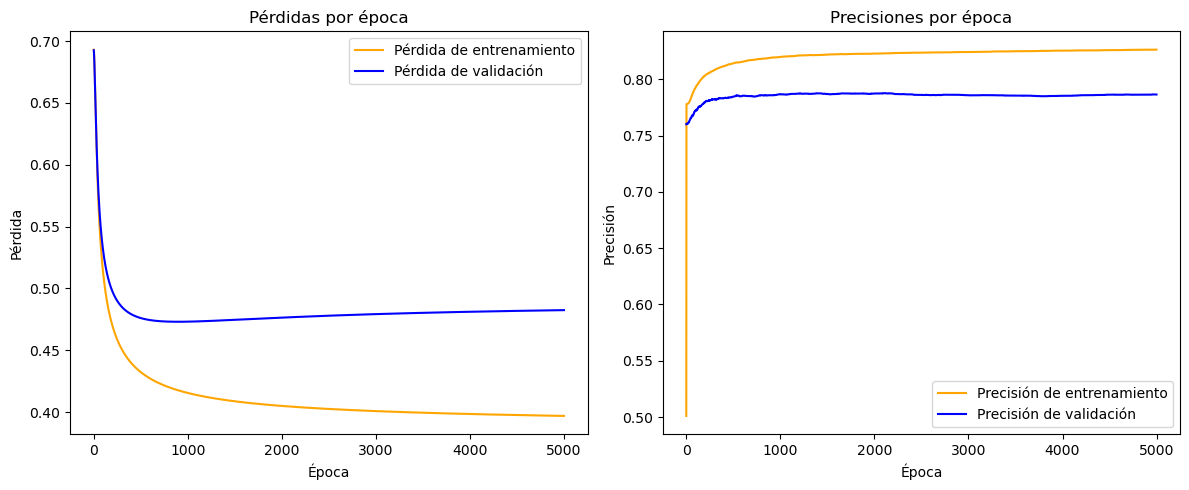

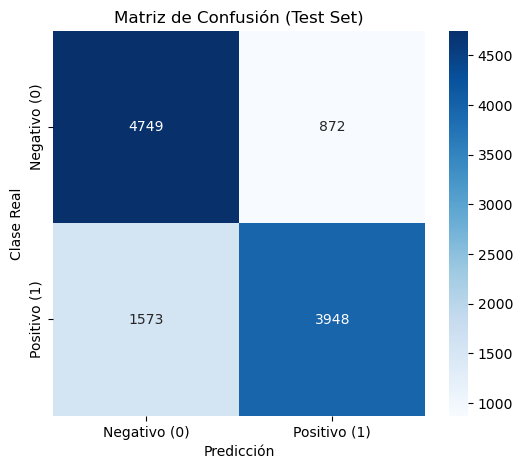

In [7]:
import matplotlib.pyplot as plt

# Graficar pérdidas y precisiones por épocas
plt.figure(figsize=(12, 5))

# Pérdidas por época
plt.subplot(1, 2, 1)
plt.plot(gd_model.losses_train, label="Pérdida de entrenamiento", color="orange")
plt.plot(gd_model.losses_val, label="Pérdida de validación", color="blue")
plt.xlabel("Época")
plt.ylabel("Pérdida")
plt.title("Pérdidas por época")
plt.legend()

# Precisión por época
plt.subplot(1, 2, 2)
plt.plot(gd_model.accuracies_train, label="Precisión de entrenamiento", color="orange")
plt.plot(gd_model.accuracies_val, label="Precisión de validación", color="blue")
plt.xlabel("Época")
plt.ylabel("Precisión")
plt.title("Precisiones por época")
plt.legend()

plt.tight_layout()
plt.show()

# Calcular matriz de confusión
cm_test = confusion_matrix(y_test, y_test_pred)

# Graficar la matriz de confusión
plt.figure(figsize=(6, 5))
sns.heatmap(cm_test, annot=True, cmap="Blues", fmt="d",
            xticklabels=["Negativo (0)", "Positivo (1)"],
            yticklabels=["Negativo (0)", "Positivo (1)"])
plt.title("Matriz de Confusión (Test Set)")
plt.xlabel("Predicción")
plt.ylabel("Clase Real")
plt.show()